## Instructions 
We will follow these instructions:

- Step 1 - Set up environment
- Step 2 - Download the BraTS2020 dataset
- Step 3 - Data exploration
- Step 4 - Prepare data for Training
- Step 5 - Define the model
- Step 6 - Train the model
- Step 7 - Predict tumor segmentations
- Step 8 - Evaluate the model

### Step 1 - Set up environment

In [96]:
pwd

'C:\\Users\\saura\\ATDL_Lab_Assignments\\Assignment_02\\Problem_02'

In [98]:
ls

 Volume in drive C is Acer
 Volume Serial Number is CC8B-1E7F

 Directory of C:\Users\saura\ATDL_Lab_Assignments\Assignment_02\Problem_02

04-02-2025  00:14    <DIR>          .
30-01-2025  16:26    <DIR>          ..
30-01-2025  16:04    <DIR>          .ipynb_checkpoints
02-02-2025  17:24    <DIR>          archive
04-02-2025  00:14         2,178,318 notebook_image_segmentation_unet.ipynb
02-02-2025  16:47               157 requirements.txt
04-02-2025  00:13                 0 training.log
               3 File(s)      2,178,475 bytes
               4 Dir(s)  32,050,941,952 bytes free


In [100]:
!pip install -r requirements.txt 

Defaulting to user installation because normal site-packages is not writeable
  Using cached nibabel-5.1.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached matplotlib-3.5.1.tar.gz (35.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached scikit_image-0.20.0-cp311-cp311-win_amd64.whl.metadata (16 kB)
  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [66 lines of output]
  Partial import of sklearn during the build process.
  setup.py:128: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
    from numpy.distutils.command.build_ext import build_ext  # noqa
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\ProgramDat

In [102]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [104]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [105]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

### Step 2 - BraTS2020 Dataset Exploration 

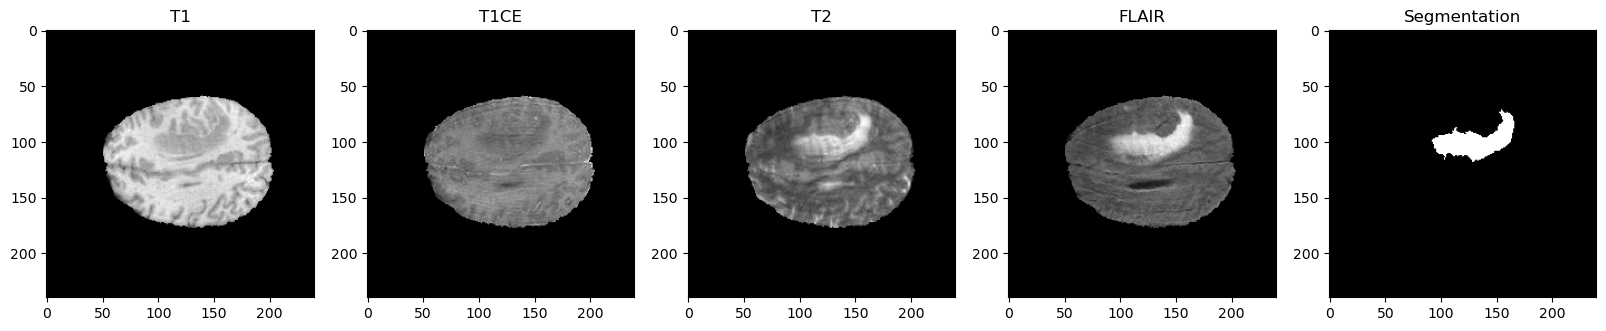

In [107]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = r'E:\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

In [109]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


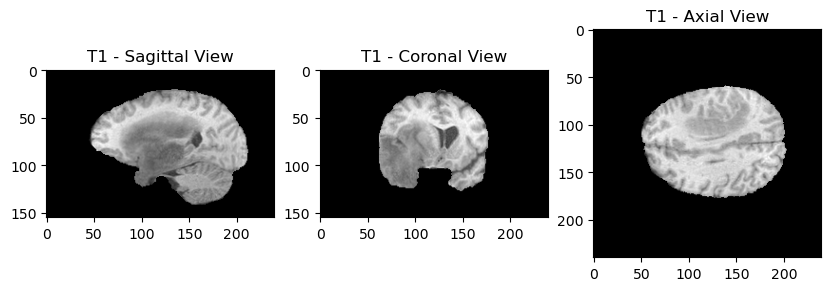

In [110]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

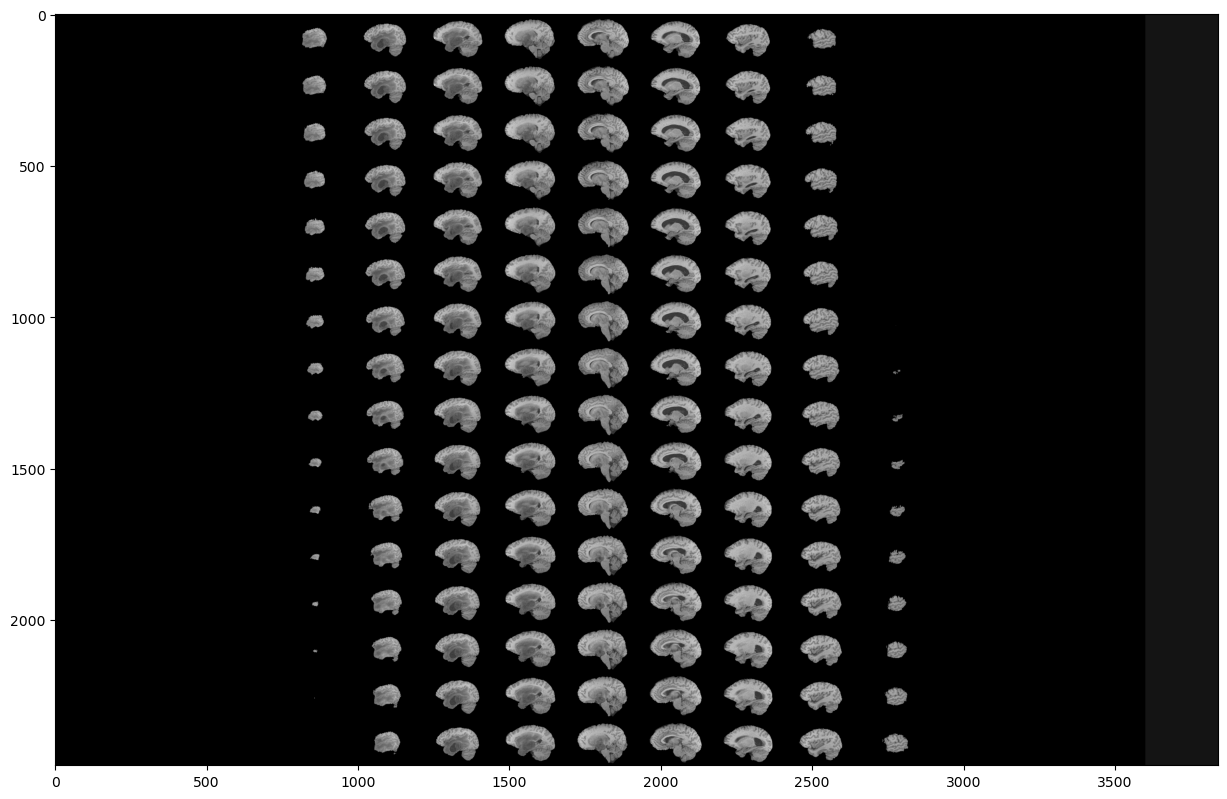

In [111]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

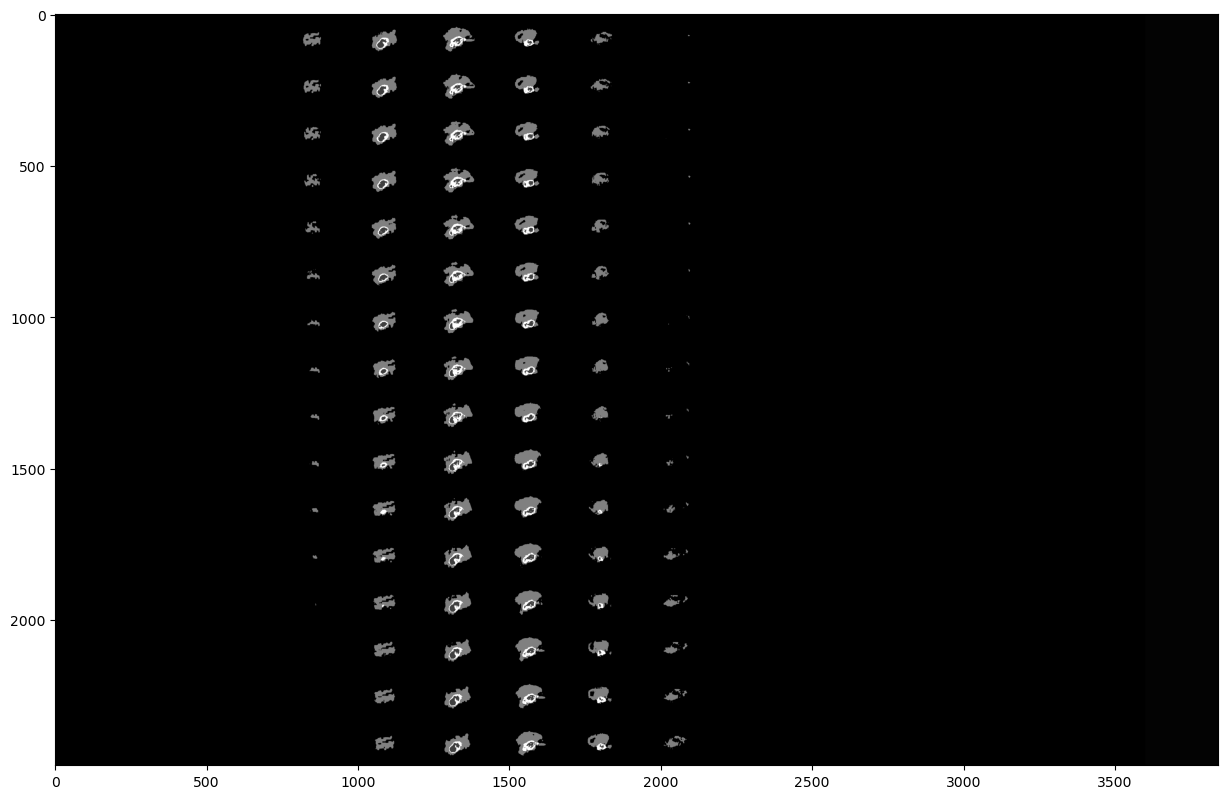

In [113]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

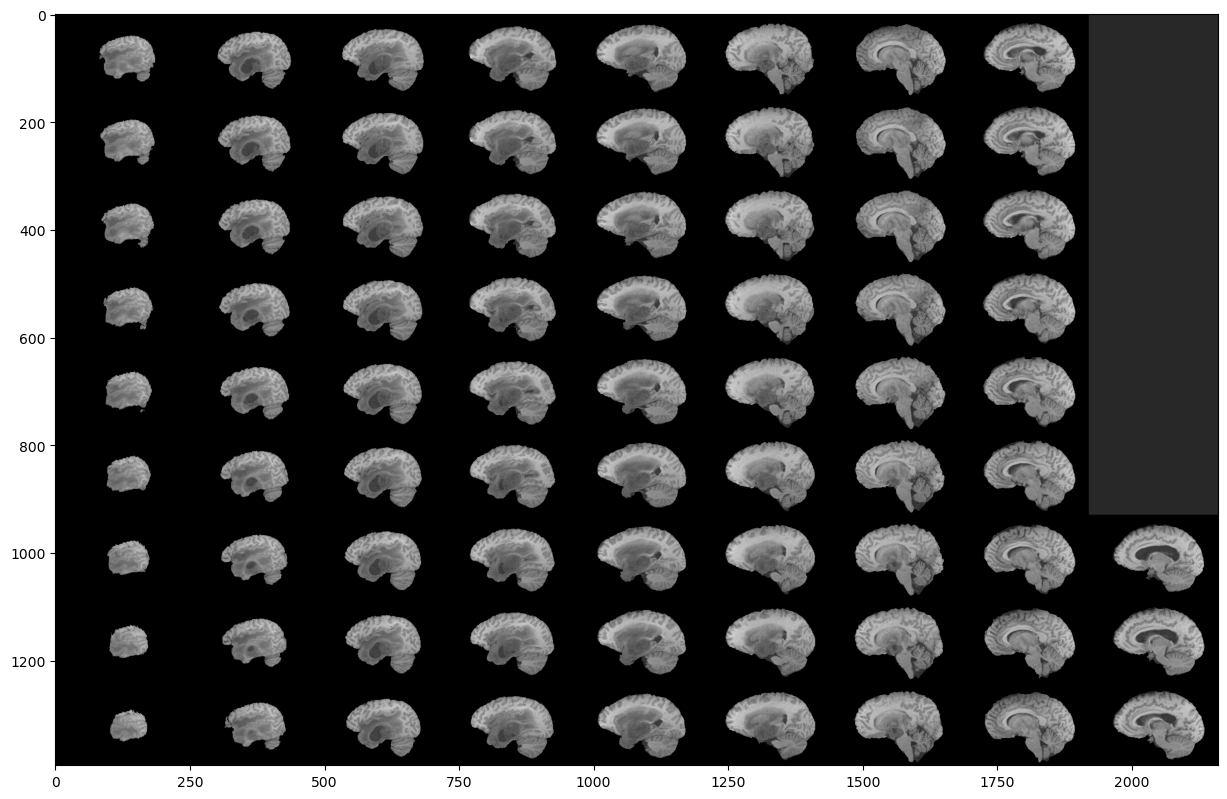

In [114]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

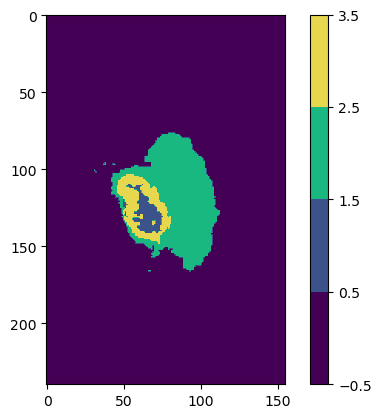

In [115]:
# Plot a segmantation
some_seg_img = nib.load(r"E:\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [116]:
data_path = r"E:\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


In [119]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


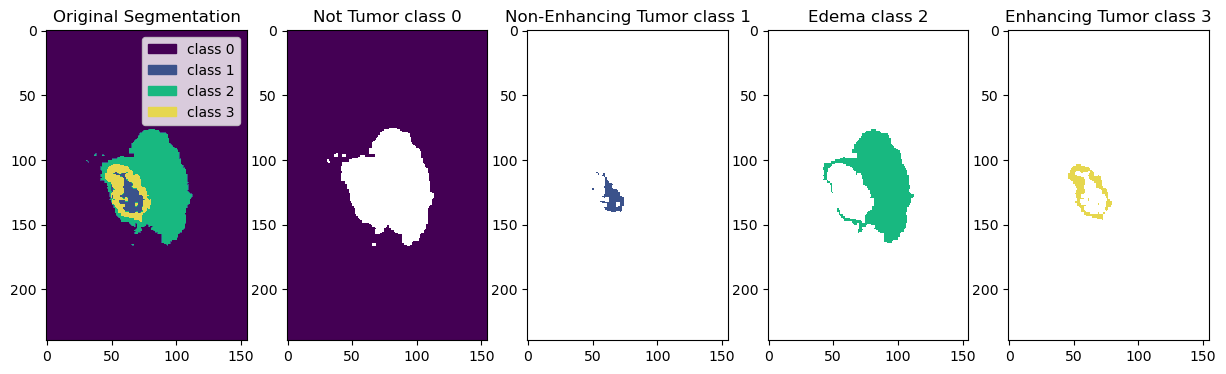

In [122]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [123]:
# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

### Step 4 - Prepare data for Training

In [125]:
# Specify path of our BraTS2020 directory
data_path = r"E:\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [127]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [129]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [130]:
pip show keras


Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: C:\Users\saura\AppData\Roaming\Python\Python311\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow_intel
Note: you may need to restart the kernel to use updated packages.


In [131]:
pip install --upgrade keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [132]:
from tensorflow.keras import utils


In [133]:
import numpy as np
import os
import nibabel as nib
import cv2
import tensorflow

IMG_SIZE = 128
VOLUME_SLICES = 100  # Define the number of slices (adjust as necessary)
VOLUME_START_AT = 10  # Define where to start slicing (adjust as necessary)
data_path = r'E:\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim  # Resized image dimensions (128 x 128)
        self.batch_size = batch_size  # Number of images to load each time
        self.list_IDs = list_IDs  # Patient IDs
        self.n_channels = n_channels  # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle  # Indicates if data is shuffled for each epoch
        self.on_epoch_end()  # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each MRI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Masks / Segmentations
        y[y == 4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X / np.max(X), Y

# Example usage of the DataGenerator
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [157]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [178]:
# Compute metric between the predicted segmentation and the ground truth
import tensorflow as tf
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):

        y_true_f = tf.keras.backend.flatten(y_true[:,:,:,i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,i])

        intersection =tf.keras.backend.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


def specificity(y_true, y_pred):
    K = tf.keras.backend  # Ensure you're using the correct backend
    
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    
    return true_negatives / (possible_negatives + K.epsilon()) 

#### E - Build the model

In [181]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [184]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath='model_{epoch:02d}-{val_loss:.6f}.weights.h5',
                                    verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger('training.log', separator=',', append=False)
]


### Step 6 - Train & Save the model

In [ ]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.9544 - dice_coef: 0.2486 - loss: 0.1976 - mean_io_u_4: 0.5837 - precision: 0.9592 - sensitivity: 0.9374 - specificity: 0.9948 
Epoch 1: val_loss improved from inf to 0.07907, saving model to model_01-0.079074.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10679s 43s/step - accuracy: 0.9545 - dice_coef: 0.2487 - loss: 0.1973 - mean_io_u_4: 0.5838 - precision: 0.9593 - sensitivity: 0.9375 - specificity: 0.9948 - val_accuracy: 0.9836 - val_dice_coef: 0.2633 - val_loss: 0.0791 - val_mean_io_u_4: 0.7192 - val_precision: 0.9835 - val_sensitivity: 0.9836 - val_specificity: 0.9945 - learning_rate: 0.0010
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.9852 - dice_coef: 0.2703 - loss: 0.0724 - mean_io_u_4: 0.6829 - precision: 0.9854 - sensitivity: 0.9844 - specificity: 0.9951 
Epoch 2: val_loss did not improve from 0.07907
250/250 ━━━━━━━━━━━━━━━━━━━━ 10227s 41s/step - accuracy: 0.9852 - dice_coef: 0.2704 - loss: 0.072

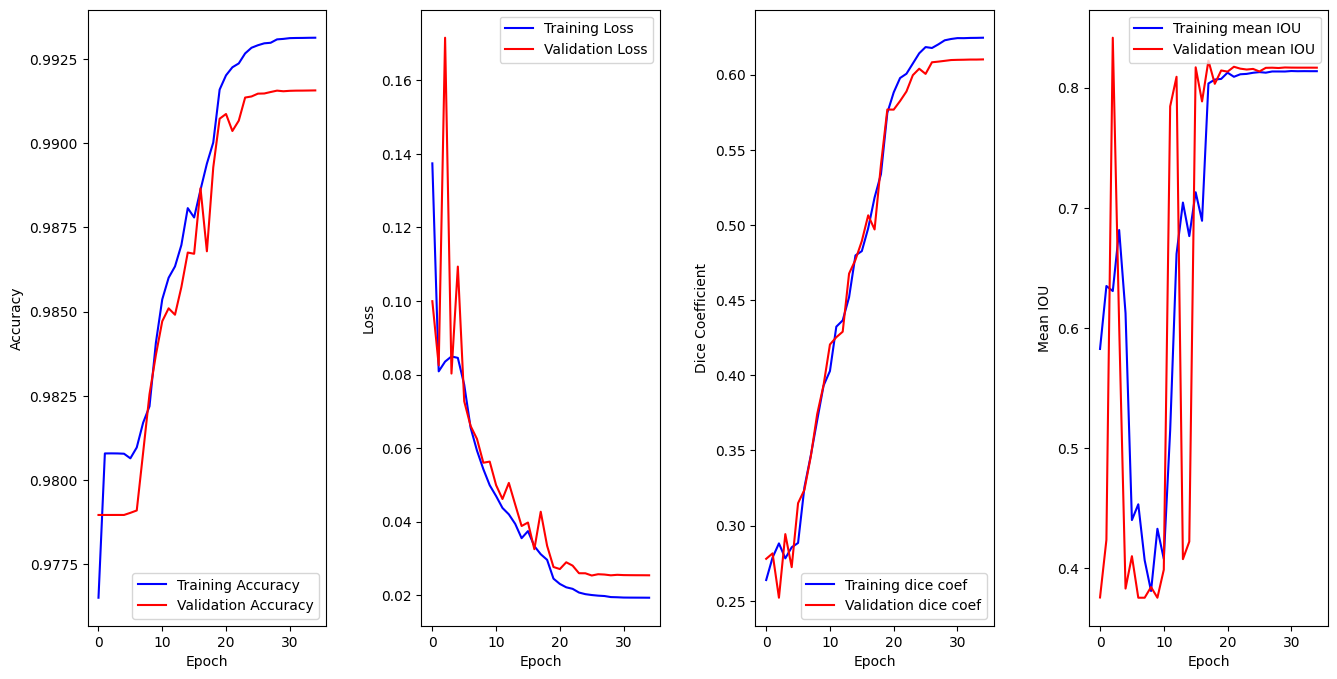

In [84]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [210]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'
            
    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    # Send our images to the CNN model and return predicted segmentation 
    return model.predict(X/np.max(X), verbose=1)

In [339]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Plot Random predictions & Compare with Original (Ground truth) 

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


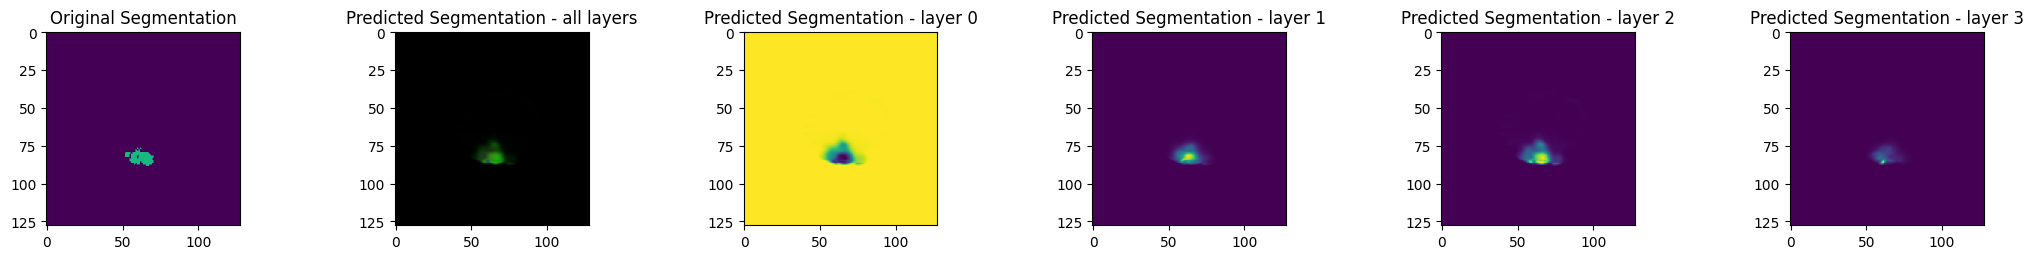

In [47]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_051


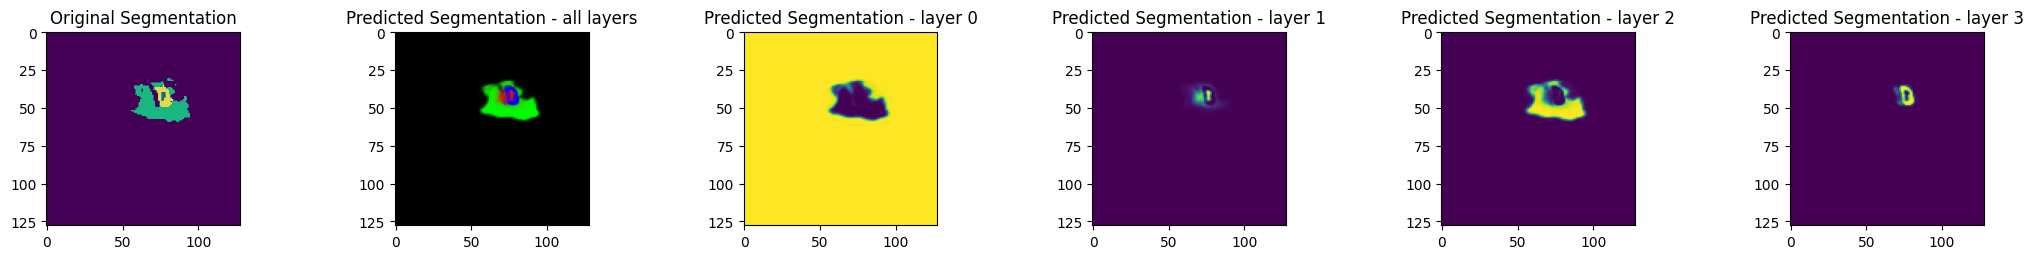

In [48]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


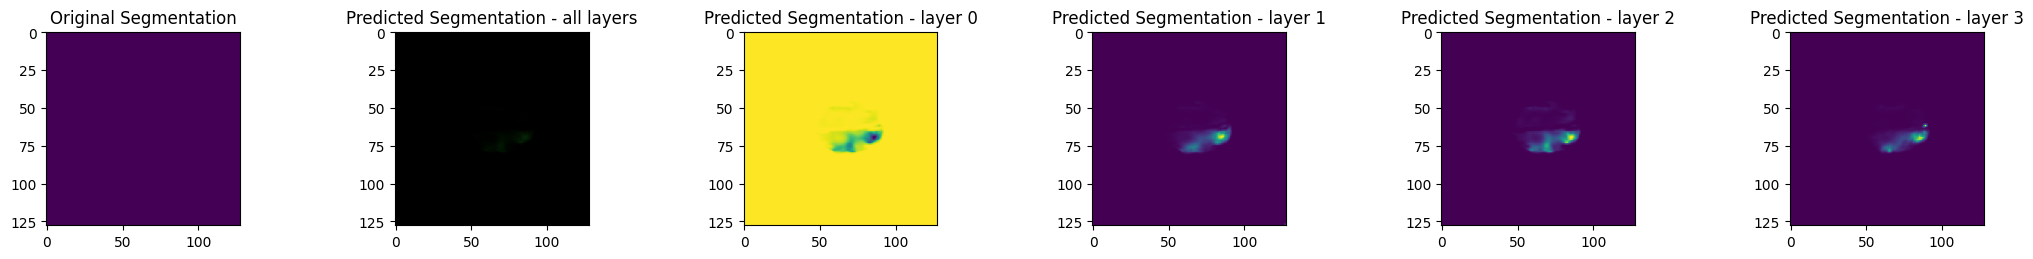

In [49]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_051


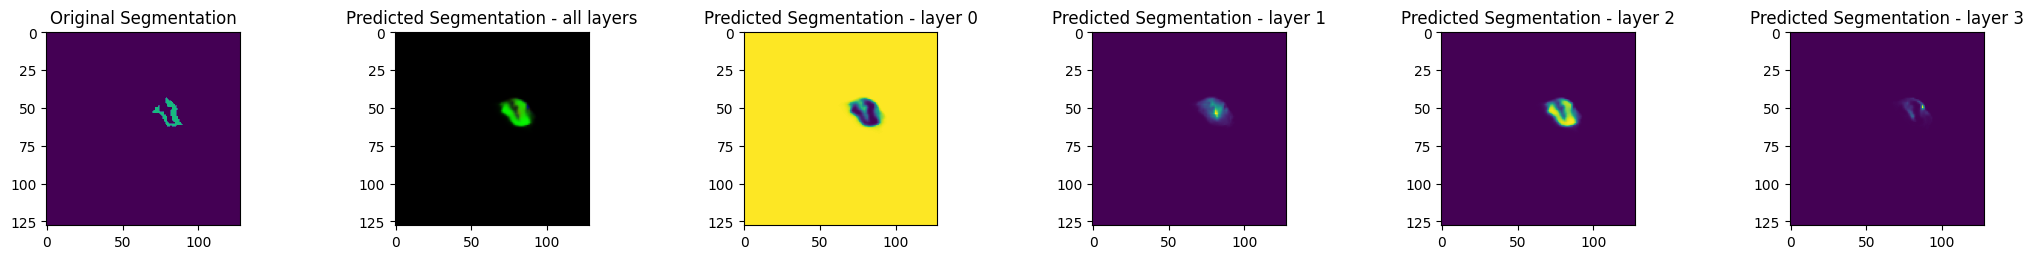

In [50]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_274


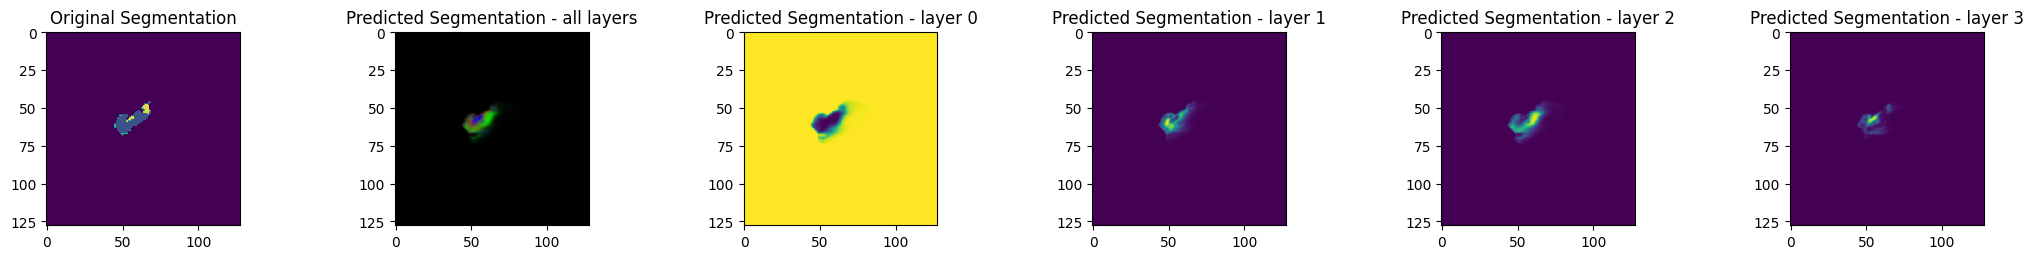

In [51]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [40]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    
    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3
    
    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan
    
    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


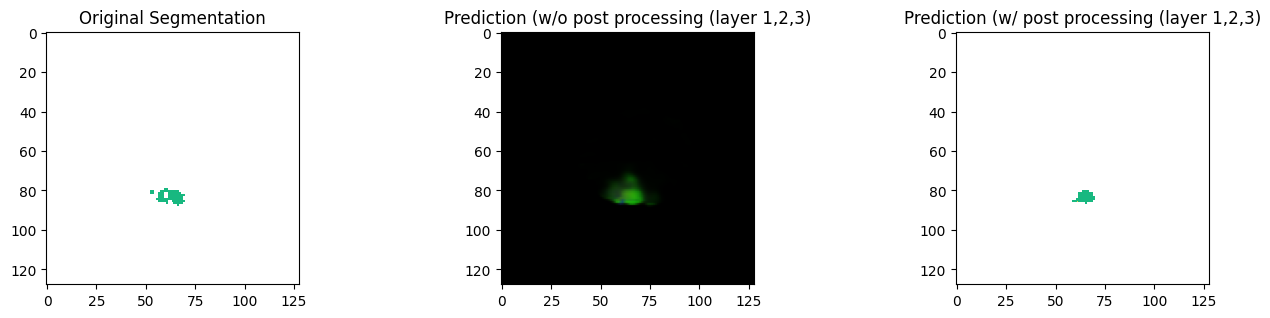

In [41]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 19ms/step
Patient number:  BraTS20_Training_051


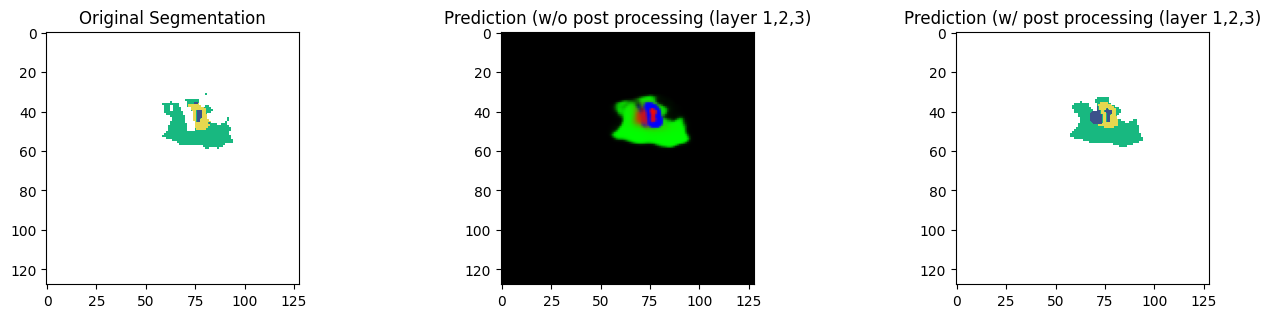

In [42]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


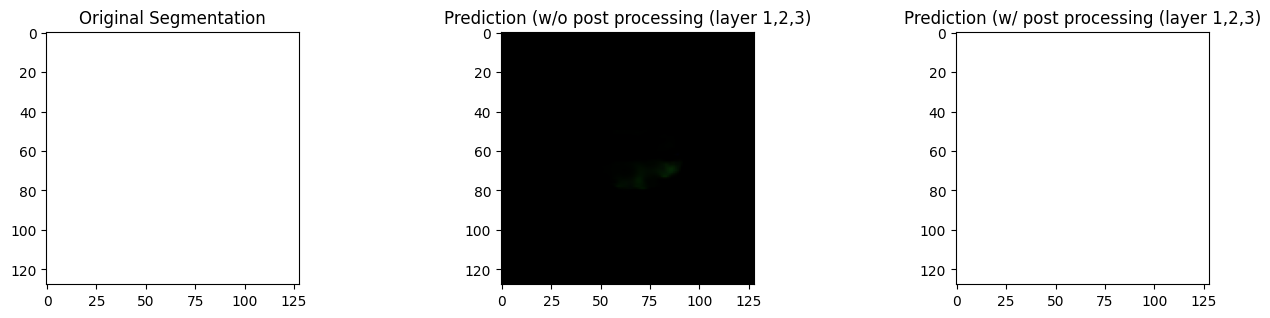

In [43]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_051


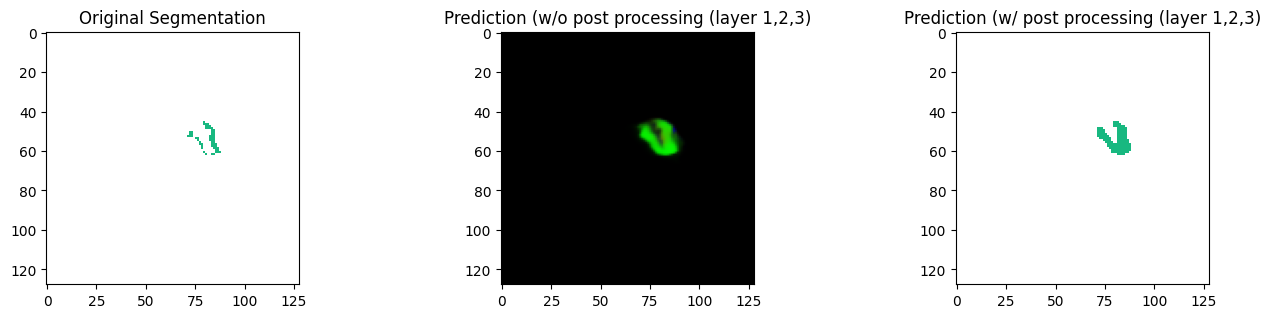

In [44]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_274


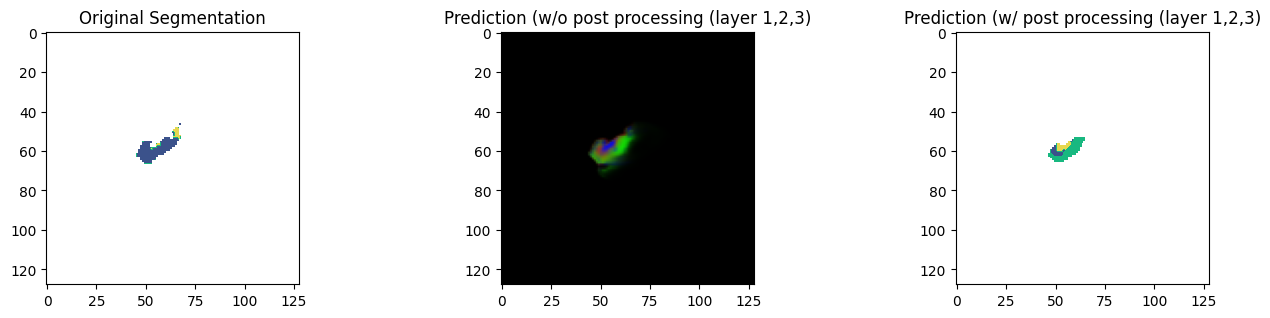

In [45]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

### Step 8 - Evaluate the model
To finish, let's call the evaluate() function to evaluate the performance of our model on our test dataset.

In [268]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 12s 260ms/step - loss: 0.0206 - accuracy: 0.9935 - mean_io_u_6: 0.8176 - dice_coef: 0.6008 - precision: 0.9938 - sensitivity: 0.9922 - specificity: 0.9979

Model evaluation on the test set:
Loss : 0.0206
Accuracy : 0.9935
MeanIOU : 0.8176
Dice coefficient : 0.6008
Precision : 0.9938
Sensitivity : 0.9922
Specificity : 0.9979
